<h1>An Exploration of Multicolinearity</h1>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm, linear_model
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
import plotly as plty
import plotly.plotly as py
import plotly.figure_factory as ff
%matplotlib inline

/Users/Katrina/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
df = pd.read_csv("../capstone/clean_data.csv")

try:
    df.drop("Unnamed: 0", axis = 1, inplace = True)
except:
    pass

ppq = pd.read_csv("../capstone/ProteinAndPathologyQuantifications.csv")
try:
    ppq.drop("Unnamed: 0", axis = 1, inplace = True)
except:
    pass

grey = pd.read_csv("../capstone/greymatter.csv")
try:
    grey.drop("Unnamed: 0", axis = 1, inplace = True)
except:
    pass

white = pd.read_csv("../capstone/whitematter.csv")
try:
    white.drop("Unnamed: 0", axis = 1, inplace = True)
except:
    pass

In [3]:
contributing_factors = ["dementia_binary",
                        "loc_cats", 
                        'num_tbi_w_loc',
                        "years_since_first_tbi",
                        "education_years", 
                        "nia_reagan",
                        #"age_at_first_tbi",  
                        "tbi_w_loc", 
                        #"age",
                        "gender",
                        "white_binary", 
                        "cerad",
                        "apo_e4_allele_binary",
                        "braak"
                       ]

factor_df = grey[contributing_factors]

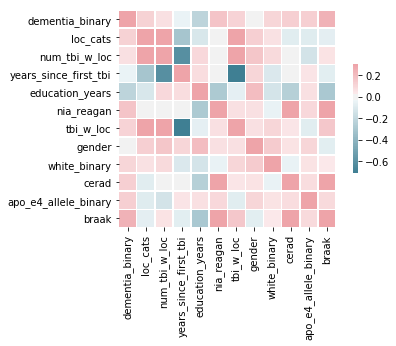

In [4]:
corr = factor_df.corr()
# mask = np.zeros_like(corr, dtype=np.bool)
# mask[np.triu_indices_from(mask)] = True

# f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [5]:
pca = PCA()
pca = pca.fit(factor_df)
factor_df_eigen_vectors = pca.explained_variance_ratio_
print('Eigenvalues for factor_df: ', factor_df_eigen_vectors)

Eigenvalues for factor_df:  [9.76182990e-01 1.29254782e-02 5.39069169e-03 3.57751271e-03
 8.26171582e-04 3.09332478e-04 2.72862186e-04 2.20759090e-04
 1.54519659e-04 9.14548428e-05 3.58178961e-05 1.24095984e-05]


In [6]:
factor_df_transformed = pca.transform(factor_df)
print('factor_df Transformed: ', factor_df_transformed)

factor_df Transformed:  [[-1.80248572e+01 -2.35075482e+00  7.60138508e-02 -2.56688500e+00
  -1.98895195e-01  8.74675310e-02 -1.54857087e-01  4.31461980e-01
  -3.13231687e-01  5.15947155e-01 -1.05476991e-01 -3.26815639e-02]
 [-1.39228163e+01 -2.04978997e+00  1.53417475e+00  2.78210133e+00
   3.64630242e-01  2.60552999e-01 -6.17494181e-01  2.12692816e-01
  -3.31469131e-02 -2.78126377e-01 -2.67708595e-01 -2.48420124e-02]
 [ 5.60512899e+01  3.74291660e+00 -1.85286532e+00 -4.65763056e-01
  -1.19756293e+00  2.38891554e-01  9.05128936e-01  3.88573406e-01
   3.71750349e-01 -3.89573515e-01  3.70928138e-03  6.50391935e-02]
 [ 6.60414826e+01  2.13692686e+00 -1.48447410e+00 -2.41024512e+00
   1.66096002e+00 -1.61823553e-01 -5.67760314e-01  1.40155378e-01
   8.49850897e-02 -6.16021629e-01  6.30224502e-02  4.91381182e-02]
 [-3.10071365e+01 -1.17467175e+00 -9.65234755e-01  1.41507013e+00
  -8.97440685e-01 -8.75341381e-02  8.68313379e-01  7.18002007e-02
   3.22859304e-01 -4.81504932e-01  9.85241531e-0

In [7]:
from statsmodels.stats.outliers_influence import variance_inflation_factor  
def calculate_vif_(X):
    variables = list(X.columns)
    vif = {variable:variance_inflation_factor(exog=X.values, exog_idx=ix) for ix,variable in enumerate(list(X.columns))}
    return vif

calculate_vif_(factor_df)

{'dementia_binary': 2.2284634082624653,
 'loc_cats': 2.782590027198459,
 'num_tbi_w_loc': 7.46462504362459,
 'years_since_first_tbi': 13.578604227546249,
 'education_years': 19.17489224908723,
 'nia_reagan': 32.130622027165806,
 'tbi_w_loc': 11.712326002270085,
 'gender': 3.183250074004336,
 'white_binary': 29.588204045415157,
 'cerad': 12.923179629307619,
 'apo_e4_allele_binary': 1.406093812198089,
 'braak': 16.889292553954217}

In [8]:
grey

,donor_id,name,age,sex,apo_e4_allele,education_years,age_at_first_tbi,longest_loc_duration,cerad,num_tbi_w_loc,...,ptau_ng_per_mg,ptau_ng_per_mg.1,gender,tbi_w_loc,white_binary,hispanic_binary,apo_e4_allele_binary,loc_cats,years_since_first_tbi,dementia_binary
0,326765665.0,H14.09.078,87,M,N,16.0,0.0,Unknown or N/A,0.0,0.0,...,0.121403,0.121403,1,0,1,0,0,0,87.0,0
1,326765656.0,H14.09.069,95,M,N,17.0,12.0,1-2 min,2.0,1.0,...,1.355935,1.355935,1,1,1,0,0,3,83.0,0
2,326765654.0,H14.09.067,85,M,Y,10.0,72.0,< 10 sec,3.0,1.0,...,0.672854,0.672854,1,1,1,0,1,1,13.0,1
3,467056391.0,H15.09.103,90,F,N,11.0,87.0,< 10 sec,0.0,1.0,...,2.262960,2.262960,0,1,1,0,0,1,3.0,0
4,309335447.0,H14.09.010,100,M,Y,16.0,0.0,Unknown or N/A,3.0,0.0,...,0.706289,0.706289,1,0,1,0,1,0,100.0,1
5,309335457.0,H14.09.020,95,F,N,18.0,0.0,Unknown or N/A,2.0,0.0,...,0.394605,0.394605,0,0,0,0,0,0,95.0,0
6,326765681.0,H14.09.094,78,M,N,18.0,0.0,Unknown or N/A,1.0,0.0,...,1.490974,1.490974,1,0,1,0,0,0,78.0,0
7,326765648.0,H14.09.061,89,F,N,16.0,6.0,< 10 sec,1.0,1.0,...,1.341696,1.341696,0,1,1,0,0,1,83.0,1
8,326765657.0,H14.09.070,95,M,N,16.0,0.0,Unknown or N/A,0.0,0.0,...,1.086812,1.086812,1,0,1,0,0,0,95.0,0
9,309335443.0,H14.09.006,90,F,N,14.0,0.0,Unknown or N/A,0.0,0.0,...,0.546749,0.546749,0,0,1,0,0,0,90.0,0


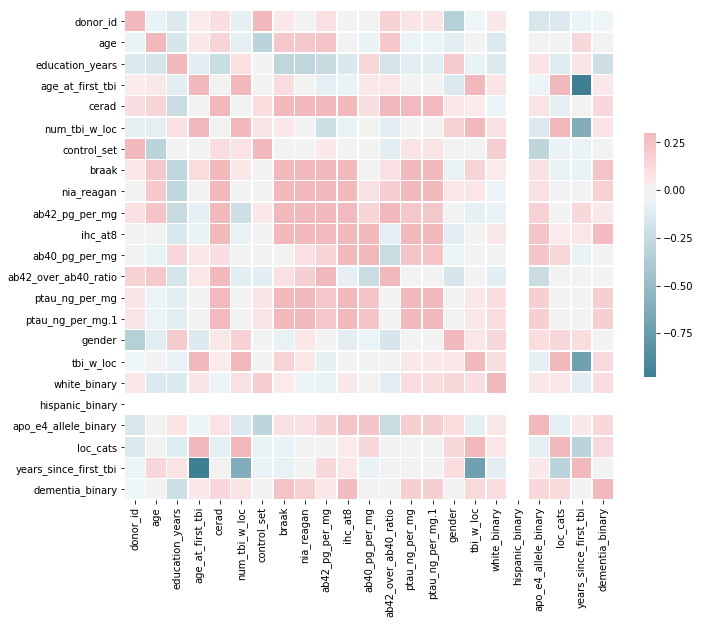

In [9]:
tbi_w_genetics = [#'ab42_pg_per_mg', 
                  #'ab42_over_ab40_ratio',
                  "dementia_binary",
                  "ptau_ng_per_mg",
                  "loc_cats", 
                  'num_tbi_w_loc',
                  "years_since_first_tbi",
                  #"education_years", 
                  "nia_reagan",
                  #"age_at_first_tbi",  
                  #"tbi_w_loc", 
                  #"age",
                  #"gender",
                  #"white_binary", 
                  "cerad",
                  "apo_e4_allele_binary"                     
]

tbi_w_genetics_df = grey[tbi_w_genetics]

tbi_w_genetics_corr = grey.corr()

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(tbi_w_genetics_corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [10]:
from statsmodels.stats.outliers_influence import variance_inflation_factor  
def calculate_vif_(X):
    variables = list(X.columns)
    vif = {variable:variance_inflation_factor(exog=X.values, exog_idx=ix) for ix,variable in enumerate(list(X.columns))}
    return vif

calculate_vif_(tbi_w_genetics_df)

{'dementia_binary': 2.088994240960363,
 'ptau_ng_per_mg': 3.4222701155943196,
 'loc_cats': 2.0527473501488958,
 'num_tbi_w_loc': 2.4425197249240527,
 'years_since_first_tbi': 3.5698767294674587,
 'nia_reagan': 20.07626734259225,
 'cerad': 12.160051653784885,
 'apo_e4_allele_binary': 1.357434527346073}

In [ ]:
tbi_corr = [#"dementia_binary",
                        "loc_cats", 
                        'num_tbi_w_loc',
                        "years_since_first_tbi",
#                         "education_years", 
                        #"nia_reagan",
                        "age_at_first_tbi",  
                        "tbi_w_loc", 
#                         "age",
#                         "gender",
                        #"white_binary", 
                        #"cerad",
                        #"apo_e4_allele_binary"
                       ]

tbi_corr_grid = (df[tbi_corr]).corr()
# mask = np.zeros_like(corr, dtype=np.bool)
# mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(tbi_corr_grid, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
plt.figure(figsize=(15, 30))
sns.heatmap(df[tbi_corr])

In [ ]:
g = sns.PairGrid(df[tbi_corr])
g = g.map_lower(sns.regplot)    # Regression plots in lower triangle.
g = g.map_upper(sns.kdeplot, cmap="Blues", shade=True, shade_lowest=False)  # KDE plots in upper triangle.
g = g.map_diag(plt.hist)        # Histograms along diagonal.

plt.show()

In [12]:
neurodegeneracy_corr = ["dementia_binary",
                        "ab42_over_ab40_ratio",
                        'ab42_pg_per_mg'
#                         "loc_cats", 
#                         'num_tbi_w_loc',
#                         "years_since_first_tbi",
#                         "education_years", 
                        "nia_reagan",
#                         "age_at_first_tbi",  
#                         "tbi_w_loc", 
#                         "age",
#                         "gender",
                        #"white_binary", 
                        "cerad",
                        "apo_e4_allele_binary"
                       ]

n_corr = (df[neurodegeneracy_corr]).corr()
# mask = np.zeros_like(corr, dtype=np.bool)
# mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(n_corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

KeyError: "['dementia_binary' 'ab42_over_ab40_ratio' 'ab42_pg_per_mgnia_reagan'\n 'apo_e4_allele_binary'] not in index"

In [13]:
plt.figure(figsize=(15, 30))
sns.heatmap(df[neurodegeneracy_corr])

KeyError: "['dementia_binary' 'ab42_over_ab40_ratio' 'ab42_pg_per_mgnia_reagan'\n 'apo_e4_allele_binary'] not in index"

<Figure size 1080x2160 with 0 Axes>

In [14]:
g = sns.PairGrid(df[neurodegeneracy_corr])
g = g.map_lower(sns.regplot)    # Regression plots in lower triangle.
g = g.map_upper(sns.kdeplot, cmap="Blues", shade=True, shade_lowest=False)  # KDE plots in upper triangle.
g = g.map_diag(plt.hist)        # Histograms along diagonal.

plt.show()

KeyError: "['dementia_binary' 'ab42_over_ab40_ratio' 'ab42_pg_per_mgnia_reagan'\n 'apo_e4_allele_binary'] not in index"

/Users/Katrina/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kernels.py:128: RuntimeWarning:

divide by zero encountered in true_divide

/Users/Katrina/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kernels.py:128: RuntimeWarning:

invalid value encountered in true_divide

/Users/Katrina/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/_kernel_base.py:513: RuntimeWarning:

invalid value encountered in true_divide

/Users/Katrina/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1480: UserWarning:


/Users/Katrina/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1481: UserWarning:


/Users/Katrina/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1480: UserWarning:


/Users/Katrina/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1481: UserWarning:


/Users/Katrina/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1480: UserWarning:


/Users/Katrina/anaconda3/lib/python3.6/site-packages

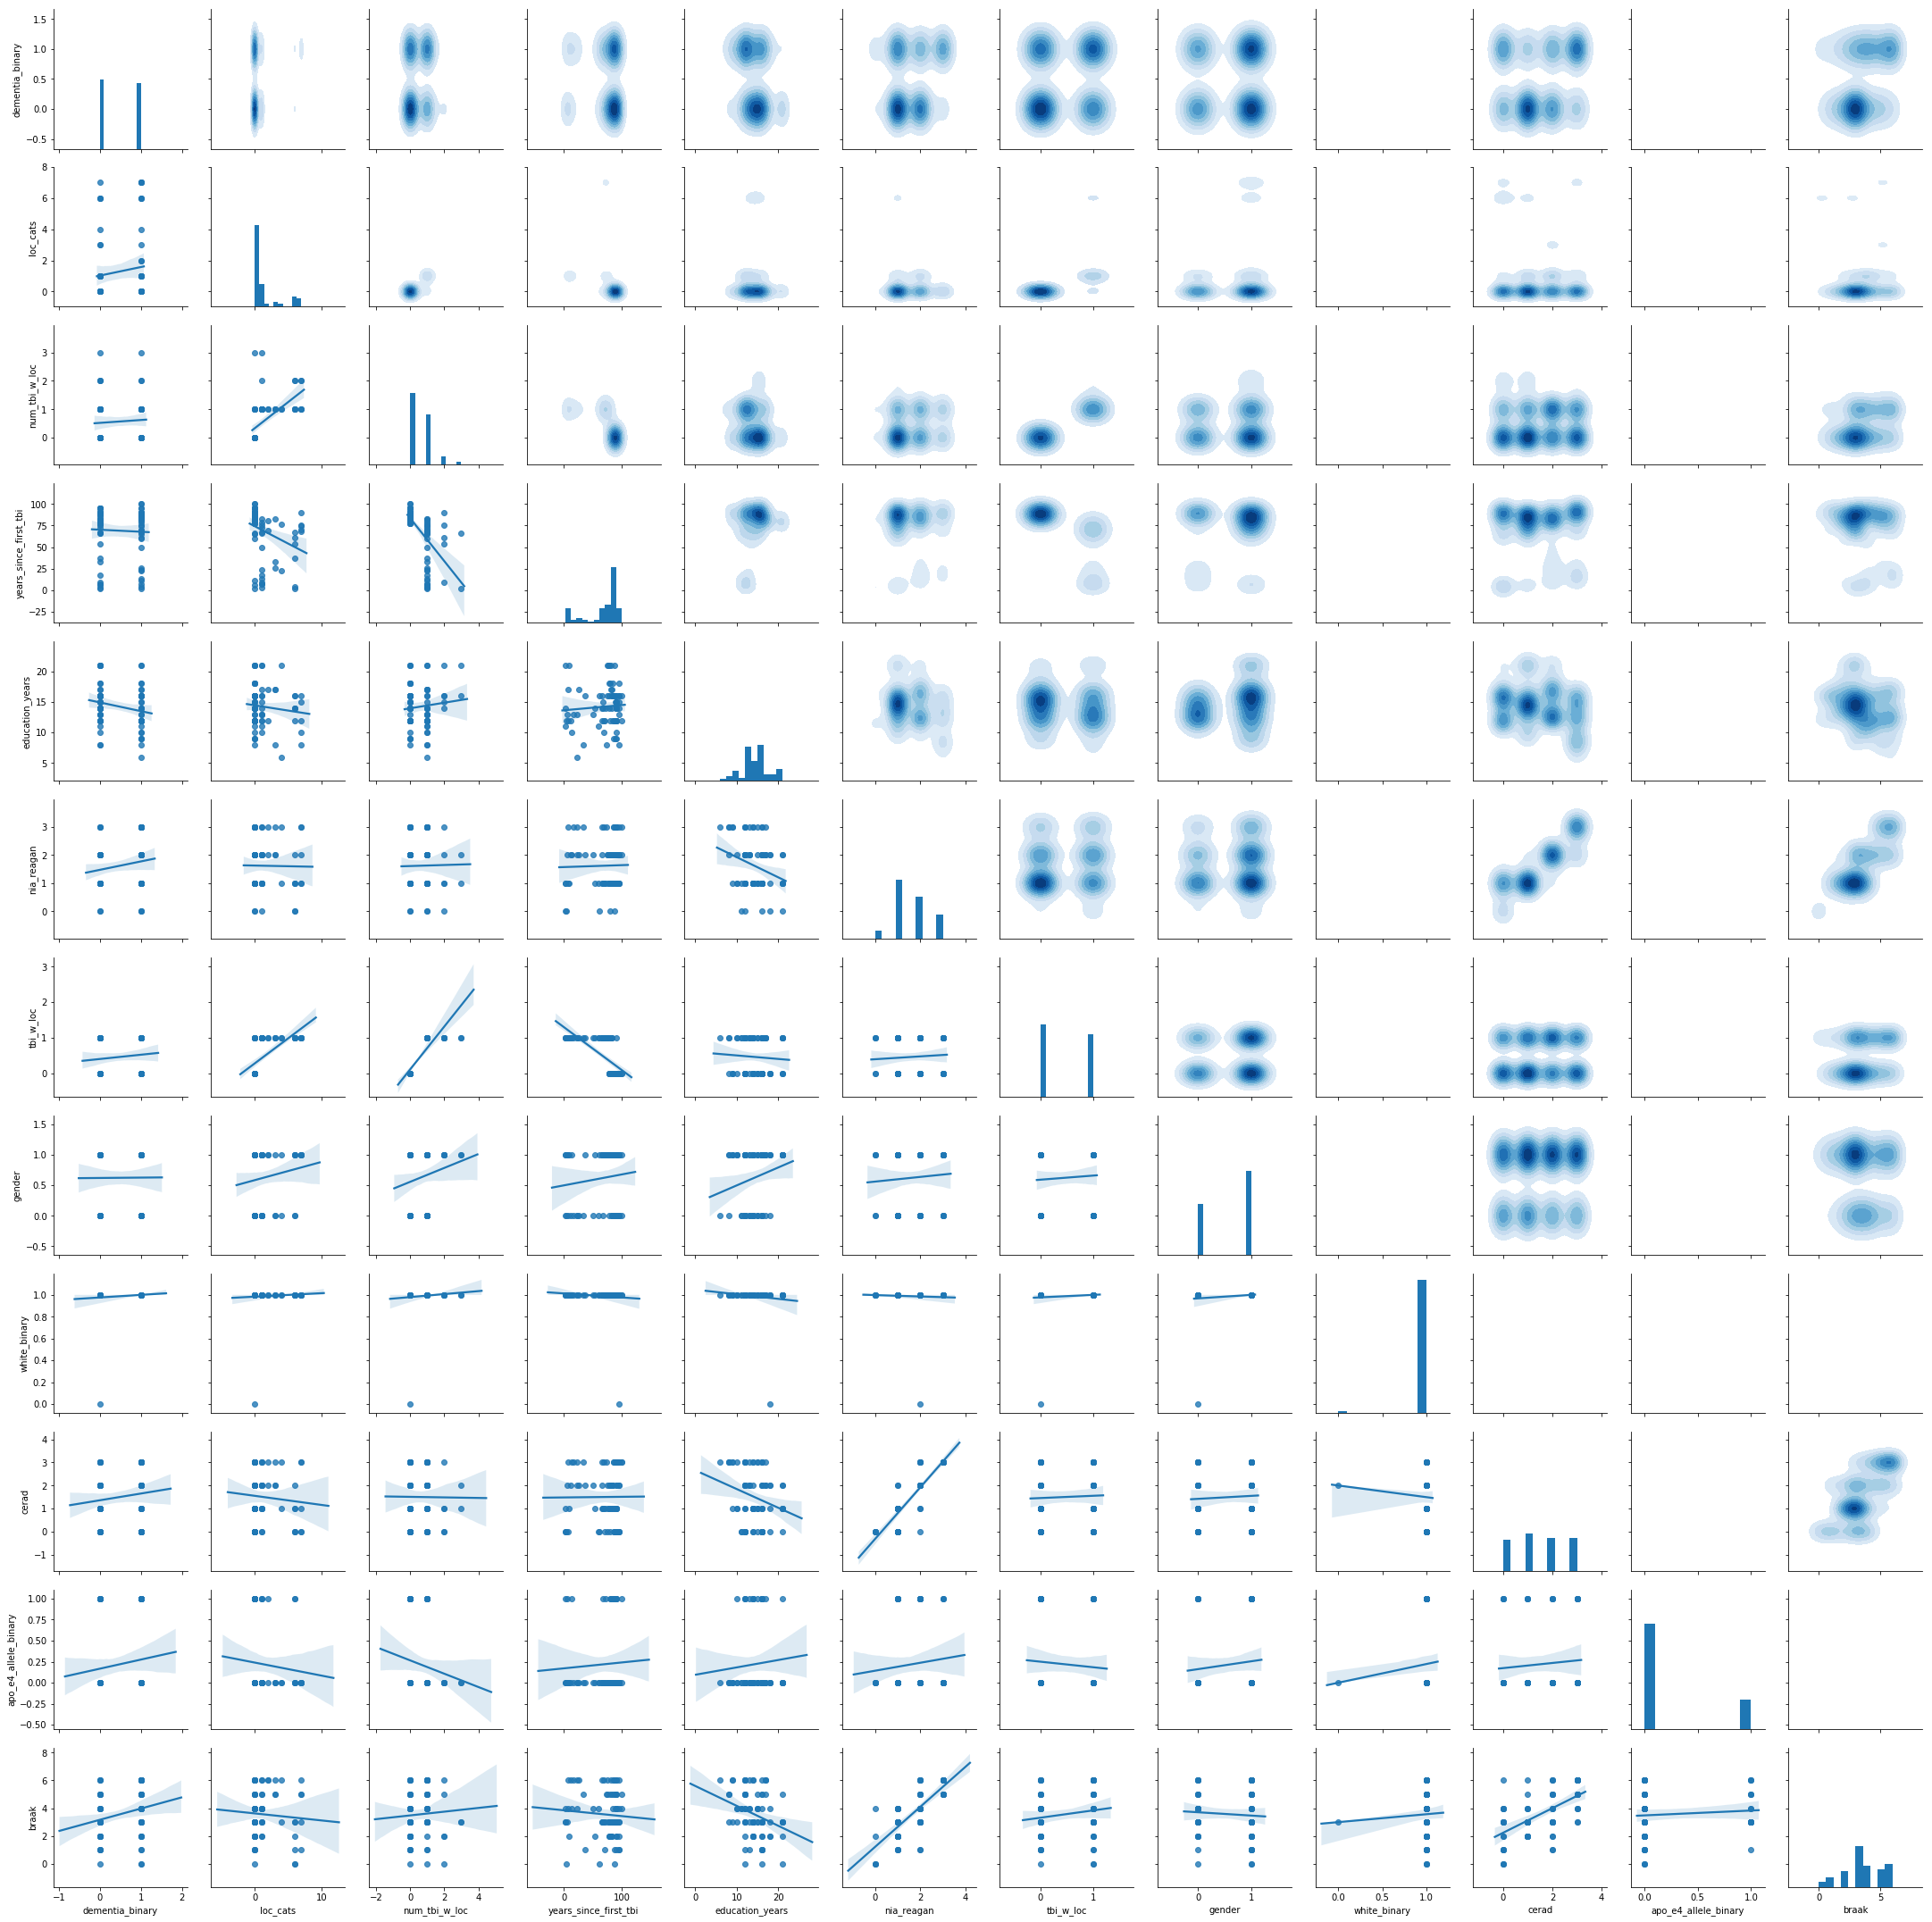

In [16]:
g = sns.PairGrid(factor_df)
g = g.map_lower(sns.regplot)    # Regression plots in lower triangle.
g = g.map_upper(sns.kdeplot, cmap="Blues", shade=True, shade_lowest=False)  # KDE plots in upper triangle.
g = g.map_diag(plt.hist)        # Histograms along diagonal.

plt.show()